In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_data = np.loadtxt('data/X.txt')
y_data = np.loadtxt('data/y.txt')

X_data, y_data = shuffle(X_data, y_data)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=800)

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7]

def plot_classes(X, y, filename=None):
    figure = plt.figure()
    class0 = y == 0
    class1 = y == 1
    plt.plot(X[class0, 0], X[class0, 1], 'ro', markersize=3, label='Class 0')
    plt.plot(X[class1, 0], X[class1, 1], 'bo', markersize=3, label='Class 1')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.legend(loc='upper left')
    if filename:
        plt.savefig(filename)
    return figure

#plot_classes(X_data, y_data, "plots/data.png")
#plt.show()

In [3]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [4]:
def prepend_ones(M):
    return np.column_stack((np.ones(M.shape[0]), M))

In [5]:
prior_variance = 1

def log_prior(w):
    return -1 / (2 * prior_variance) * (w.T @ w)

In [6]:
def log_likelihood(w, X, y):
    X1 = prepend_ones(X)
    sigma = logistic(X1 @ w)
    return np.sum(y * np.log(sigma)
                  + (1 - y) * np.log(1 - sigma))

def negative_log_likelihood(w, X, y):
    return -log_likelihood(w, X, y)

def log_likelihood_gradient(w, X, y):
    X1 = prepend_ones(X)
    return (y - logistic(X1 @ w)) @ X1

def negative_log_likelihood_gradient(w, X, y):
    return -log_likelihood_gradient(w, X, y)

In [7]:
def mean_log_likelihood(w, X, y):
    return log_likelihood(w, X, y) / y.len()

In [8]:
def log_posterior(w, X, y):
    return log_likelihood(w, X, y) + log_prior(w)

def negative_log_posterior(w, X, y):
    return -log_posterior(w, X, y)

def posterior_gradient(w, X, y):
    X1 = prepend_ones(X)
    return (y - logistic(X1 @ w)) @ X1 - w / prior_variance

def negative_posterior_gradient(w, X, y):
    return -posterior_gradient(w, X, y)

In [9]:
from scipy.optimize import fmin_l_bfgs_b as minimise

def find_w_map(X, y, w0=None):
    if w0 is None:
        w0 = np.random.normal(size=X.shape[1] + 1)
    w_map, posterior_at_wmap, d = minimise(negative_log_posterior,
                                           w0,
                                           negative_posterior_gradient,
                                           args=[X, y])
    return w_map
    
def find_w_ml(X, y, w0=None):
    if w0 is None:
        w0 = np.random.normal(size=X.shape[1] + 1)
    w_ml, likelihood_at_wml, d = minimise(negative_log_likelihood,
                                          w0,
                                          negative_log_likelihood_gradient,
                                          args=[X, y])
    return w_ml

In [10]:
def evaluate_basis_functions(l, X, Z):
    X2 = np.sum(X**2, 1)
    Z2 = np.sum(Z**2, 1)
    ones_Z = np.ones(Z.shape[ 0 ])
    ones_X = np.ones(X.shape[ 0 ])
    r2 = np.outer(X2, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z2)
    return np.exp(-0.5 / l**2 * r2)

width = 0.1

X_train_expanded = evaluate_basis_functions(width, X_train, X_train)
X_test_expanded = evaluate_basis_functions(width, X_test, X_train)

In [11]:
w_map = find_w_map(X_train_expanded, y_train)

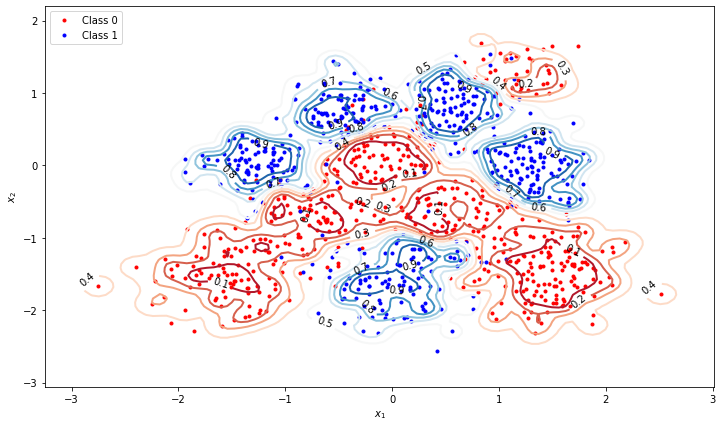

In [12]:
def plot_predictive_distribution(inputs, labels, weights,
                                 map_inputs = lambda x : x,
                                 predictive_function=None,
                                 filename=None):
    if predictive_function is None:
        predictive_function = lambda inputs_, weights_: logistic(inputs_ @ weights)
    plot_classes(inputs, labels)
    x_min, x_max = inputs[ :, 0 ].min() - .5, inputs[ :, 0 ].max() + .5
    y_min, y_max = inputs[ :, 1 ].min() - .5, inputs[ :, 1 ].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_expanded = map_inputs(np.concatenate((xx.ravel().reshape((-1, 1)),
                                               yy.ravel().reshape((-1, 1))), 1))
    Z = predictive_function(grid_expanded, weights)
    Z = Z.reshape(xx.shape)
    contours = plt.contour(xx, yy, Z, cmap='RdBu', levels=10, linewidths=2)
    plt.clabel(contours, fontsize=10, fmt='%2.1f', colors='k')
    if filename:
        plt.savefig(filename)
    plt.show()
    
plot_predictive_distribution(X_data, y_data, w_map,
                             lambda x: prepend_ones(evaluate_basis_functions(width, x, X_train)))

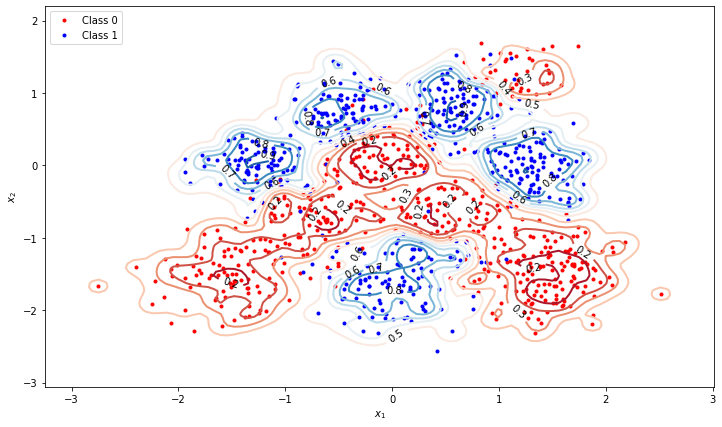

In [13]:
def laplace_predictive_distribution(inputs, weights):
    global X_train_expanded
    global prior_variance
    global w_map
    X_tilde = prepend_ones(X_train_expanded)
    sigma = logistic(X_tilde @ weights)
    C_N = np.linalg.inv(np.identity(weights.shape[0])/prior_variance
                        + X_tilde @ X_tilde.T @ sigma @ (1-sigma))
    predictive_mean = inputs @ w_map
    predictive_variance = np.empty(inputs.shape[0])
    for i, x in enumerate(inputs):
        predictive_variance[i] = x.T @ C_N @ x
    return logistic(predictive_mean / np.sqrt(1 + predictive_variance*np.pi/8))
    
plot_predictive_distribution(X_data, y_data, w_map,
                             lambda x: prepend_ones(evaluate_basis_functions(width, x, X_train)),
                             laplace_predictive_distribution)

In [14]:
def confusion_matrix(weights, test_data, test_labels):
    class_probabilities = logistic(prepend_ones(test_data) @ weights)
    predicted_class1 = class_probabilities <= 0.5
    predicted_class2 = class_probabilities > 0.5
    correctly_predicted_class1 = np.sum(np.logical_and(predicted_class1, test_labels == 0)) / np.sum(test_labels == 0)
    incorrectly_predicted_class1 = np.sum(np.logical_and(predicted_class1, test_labels == 1)) / np.sum(test_labels == 1)
    correctly_predicted_class2 = np.sum(np.logical_and(predicted_class2, test_labels == 1)) / np.sum(test_labels == 1)
    incorrectly_predicted_class2 = np.sum(np.logical_and(predicted_class2, test_labels == 0)) / np.sum(test_labels == 0)

    print(f"[[{correctly_predicted_class1:.3f}, {incorrectly_predicted_class2:.3f}],\n"
          f" [{incorrectly_predicted_class1:.3f}, {correctly_predicted_class2:.3f}]]")
